In [49]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense,TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks

In [50]:
data_set_contaminantes = pd.read_csv('./Dataset_MinMax.csv',sep=';',decimal=',')
data_set_contaminantes['fecha'] = pd.to_datetime(data_set_contaminantes['fecha'])
data_set_contaminantes.sort_values('fecha', inplace=True)
data_set_contaminantes.columns

mensaje=""


In [51]:
data_set_contaminantes = data_set_contaminantes.drop('fecha', axis=1)
data_set_contaminantes = data_set_contaminantes.drop('calidad_aire', axis=1)
data_set_contaminantes = data_set_contaminantes.drop(columns=['dia','mes'],axis=1) 
data_set_contaminantes = data_set_contaminantes.drop(columns=['year'],axis=1)
data_set_contaminantes = data_set_contaminantes.drop(columns=['dir_viento'],axis=1)
data_set_contaminantes = data_set_contaminantes.drop(columns=['estacion'],axis=1)
data_set_contaminantes = data_set_contaminantes.drop(columns=['AQI','dir_viento_cos','dir_viento_sin'],axis=1)
data_set_contaminantes = data_set_contaminantes.drop(columns=['puntoRocio'],axis=1)

# 'dia_sin','dia_cos'
# data_set_contaminantes = data_set_contaminantes.drop(columns=['dia_sin','dia_cos','dir_viento_cos','dir_viento_sin'],axis=1)
                                    
data_set_contaminantes.columns

Index(['pm2.5', 'pm10', 'humedad', 'temperatura', 'viento', 'precipitacion',
       'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos'],
      dtype='object')

In [52]:
def create_sequences(df, target_columns, n_steps, horizon):

    batch_size=32
    test_size = 0.2
    X, y = [], []
    # Crear secuencias
    for i in range(len(df) - n_steps - horizon + 1):
        seq_x = df.iloc[i:(i + n_steps)].values
        seq_y = df[target_columns].iloc[(i + n_steps):(i + n_steps + horizon)].values
        X.append(seq_x)
        y.append(seq_y)

    X, y = np.array(X), np.array(y)
    
    # Asegurar que el tamaño total de los datos sea múltiplo del batch_size
    total_exceso = X.shape[0] % batch_size
    if total_exceso > 0:
        X = X[:-total_exceso]
        y = y[:-total_exceso]

    # Determinar el punto de corte para no mezclar datos y mantener la secuencia temporal
    train_size = int(len(X) * (1 - test_size))
    
    # Ajustar train_size para que sea múltiplo del batch_size
    train_exceso = train_size % batch_size
    if train_exceso > 0:
        train_size -= train_exceso
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test




In [53]:
def createRNN(n_steps,horizon):


    X_train, X_test, y_train, y_test = create_sequences(data_set_contaminantes, ['pm2.5', 'pm10'], n_steps, horizon)



    model = Sequential()
    model.add(
        SimpleRNN(units= 40,
                activation="relu", 
                return_sequences=True,
                input_shape=(X_train.shape[1], X_train.shape[2])
                )
    )
    model.add(SimpleRNN(units=20, activation="relu",return_sequences=True))

    model.add(SimpleRNN(units=15, activation="relu",return_sequences=True))    
    model.add(TimeDistributed(Dense(units=2)))


    opt = Adam(learning_rate=0.00001)
    model.compile(optimizer=opt, loss='mse')


    
    return model,X_train, X_test, y_train, y_test

In [54]:
def train_model(model,X_train,y_train,X_test, y_test):
    early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # cantidad mínima de cambio para contar como una mejora
    patience=200, # cuántas épocas esperar antes de detener
    restore_best_weights=True,
    )
 
    history = model.fit(X_train, y_train, epochs=100,validation_split=0.1,verbose=0,callbacks=[early_stopping])
    # y_pred = model.predict(X_test)
    return model,history
    


In [55]:
n_steps = 1
horizon = 1


model,X_train, X_test, y_train, y_test = createRNN(n_steps,horizon) # se crea con un numero de step backs y un horizonte


model,history= train_model(model,X_train,y_train,X_test, y_test)

y_pred = model.predict(X_test)

print(y_pred.shape)

24/24 [==============================] - 0s 956us/step
(768, 1, 2)


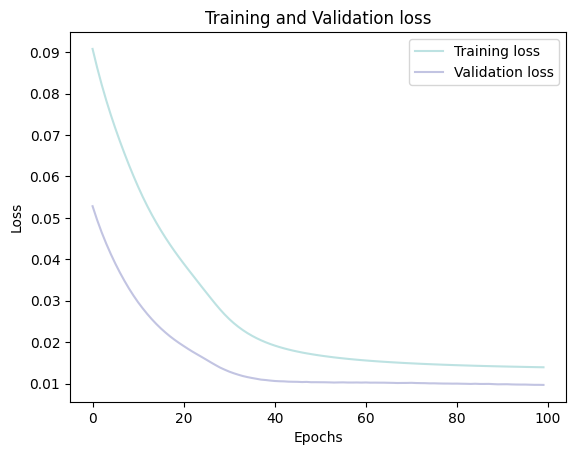

In [56]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

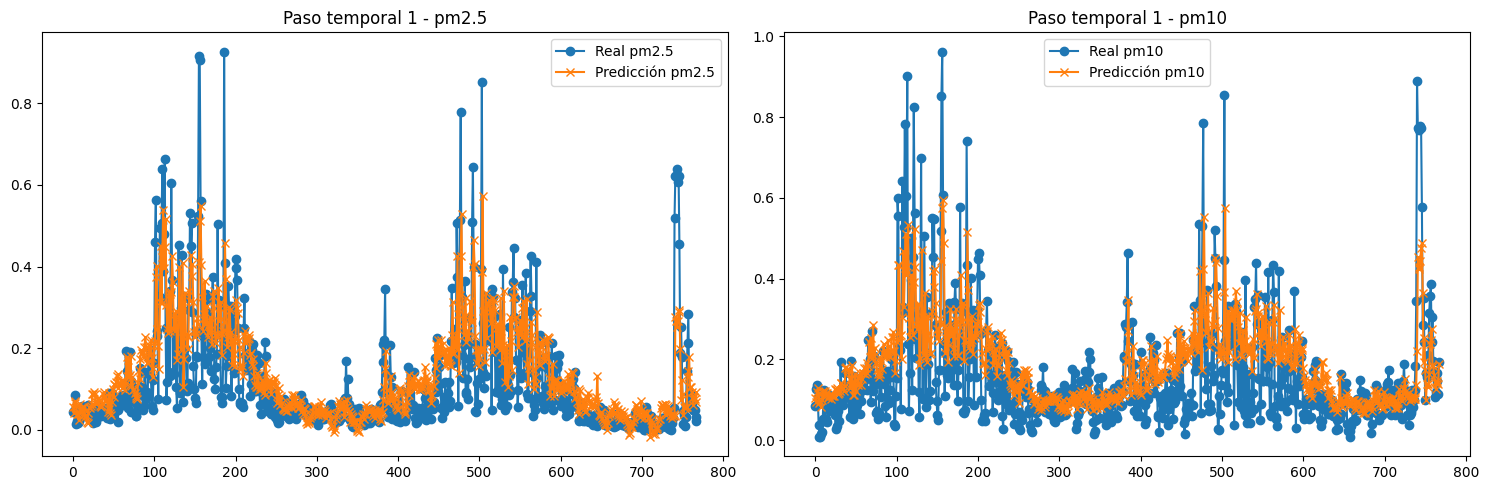

In [57]:
# Extraer y aplanar las predicciones y los valores reales para cada paso temporal
# horizon= 2
fig, axes = plt.subplots(horizon, 2, figsize=(15, 5*horizon), squeeze=False)

for i in range(horizon):
    # Datos reales para el paso temporal i
    real_time_step_data = y_test[:, i, :]
    # Predicciones para el paso temporal i
    pred_time_step_data = y_pred[:, i, :]

    # Graficar los datos reales y las predicciones para pm2.5
    axes[i][0].plot(real_time_step_data[:, 0], 'o-', label='Real pm2.5')
    axes[i][0].plot(pred_time_step_data[:, 0], 'x-', label='Predicción pm2.5')
    axes[i][0].set_title(f'Paso temporal {i+1} - pm2.5')
    axes[i][0].legend()

    # Graficar los datos reales y las predicciones para pm10
    axes[i][1].plot(real_time_step_data[:, 1], 'o-', label='Real pm10')
    axes[i][1].plot(pred_time_step_data[:, 1], 'x-', label='Predicción pm10')
    axes[i][1].set_title(f'Paso temporal {i+1} - pm10')
    axes[i][1].legend()

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()



In [58]:
# print('y_pred',y_pred)
# print('y_test',y_test)

# print(y_pred.shape)

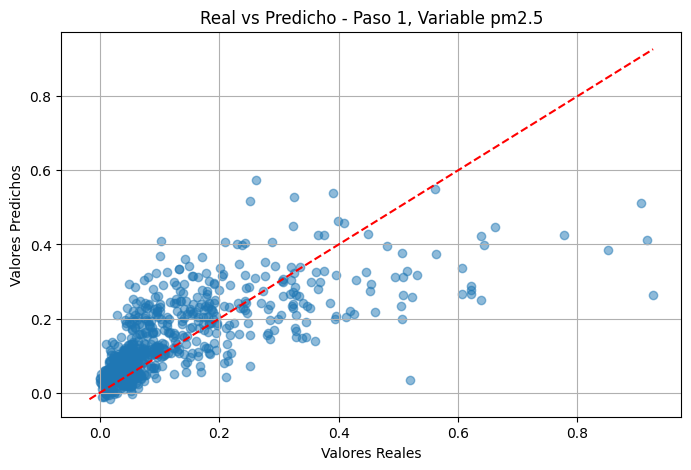

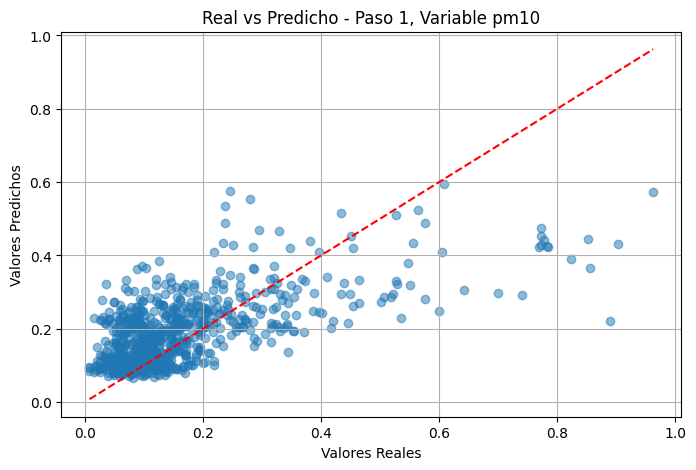

In [59]:
import matplotlib.pyplot as plt

def func(j):
    if j==0:
        return 'pm2.5'
    return 'pm10'


for i in range(horizon):
    for j in range(y_pred.shape[2]): 
        plt.figure(figsize=(8, 5))
        plt.scatter(y_test[:, i, j], y_pred[:, i, j], alpha=0.5)
        min_val = min(y_test[:, i, j].min(), y_pred[:, i, j].min())
        max_val = max(y_test[:, i, j].max(), y_pred[:, i, j].max())
        jota= func(j)
        # diagonal
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
        plt.title(f'Real vs Predicho - Paso {i+1}, Variable {jota}')
        plt.xlabel('Valores Reales')
        plt.ylabel('Valores Predichos')
        plt.grid(True)
        plt.show()


In [60]:
print(y_test.shape)
print(y_pred.shape)
print(horizon)


(768, 1, 2)
(768, 1, 2)
1


In [61]:
import pickle

def getScaler():
    features_indices = [0, 1]
    with open('../scaler_minmax.pkl', 'rb') as file:
        loaded_scaler = pickle.load(file)

    # Crear un nuevo MinMaxScaler
    scaler = MinMaxScaler()
    scaler.min_ = loaded_scaler.min_[features_indices]
    scaler.scale_ = loaded_scaler.scale_[features_indices]
    scaler.data_min_ = loaded_scaler.data_min_[features_indices]
    scaler.data_max_ = loaded_scaler.data_max_[features_indices]
    scaler.data_range_ = loaded_scaler.data_range_[features_indices]
    return scaler






scaler = getScaler()




y_test_reshaped = y_test.reshape(-1, 2)  # (cantidad de muestras * pasos temporales, número de características)
y_pred_reshaped = y_pred.reshape(-1, 2)  

# transformacion inversa
y_test_original = scaler.inverse_transform(y_test_reshaped)
y_pred_original = scaler.inverse_transform(y_pred_reshaped)


num_steps = y_test.shape[1] 
num_features = y_test.shape[2]  

# Volver a redimensionar a la forma original considerando el horizonte
y_test = y_test_original.reshape(-1, num_steps, num_features)
y_pred = y_pred_original.reshape(-1, num_steps, num_features)



mse_per_step = []
rmse_per_step = []
mae_per_step = []
r2_per_step = []



variable_dict = {
    0: 'pm2.5',
    1: 'pm10'
}
metrics_data1 = {
    'Paso Temporal': [],
    'Variable': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'R^2': []
}






for i in range(horizon):
    for j in range(2):
        # Calcular las métricas para la variable j en el paso temporal i
        mse_temporal = mean_squared_error(y_test[:, i, j], y_pred[:, i, j])
        rmse_temporal = np.sqrt(mse_temporal)
        mae_temporal = mean_absolute_error(y_test[:, i, j], y_pred[:, i, j])
        r2_temporal = r2_score(y_test[:, i, j], y_pred[:, i, j])
        
        # Agregar a las listas
        mse_per_step.append(mse_temporal)
        rmse_per_step.append(rmse_temporal)
        mae_per_step.append(mae_temporal)
        r2_per_step.append(r2_temporal)







for i in range(horizon):
    for j in range(2):
        metrics_data1['Paso Temporal'].append(i + 1)
        metrics_data1['Variable'].append(variable_dict[j])
        idx = i * 2 + j  # Calcular el índice para las listas de metricas
        metrics_data1['MSE'].append(mse_per_step[idx])
        metrics_data1['RMSE'].append(rmse_per_step[idx])
        metrics_data1['MAE'].append(mae_per_step[idx])
        metrics_data1['R^2'].append(r2_per_step[idx])






metrics_df1 = pd.DataFrame(metrics_data1)
metrics_df1



,Paso Temporal,Variable,MSE,RMSE,MAE,R^2
0,1,pm2.5,338.433828,18.396571,12.175059,0.501862
1,1,pm10,456.300839,21.361199,15.105775,0.385444


In [62]:
# convertimos el modelo a un dataframe

import io
import re
# Function to convert model summary to a DataFrame
def model_summary_to_dataframe(model):
    stream = io.StringIO()
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    summary_string = stream.getvalue()
    stream.close()

    # Regular expression to match the lines with layer information
    layer_regex = re.compile(r'([\w\d_]+)\s+\(([\w\d_]+)\)\s+(\([\w\d,\s]+\))\s+(\d+)')

    # Find all layer lines using the regular expression
    layer_lines = layer_regex.findall(summary_string)

    # Parse the matched lines into a DataFrame
    df = pd.DataFrame(layer_lines, columns=['Layer Name', 'Layer Type', 'Output Shape', 'Param #'])

    return df

df_summary = model_summary_to_dataframe(model)
print(df_summary)

      Layer Name Layer Type   Output Shape Param #
0   simple_rnn_9  SimpleRNN  (None, 1, 40)    2040
1  simple_rnn_10  SimpleRNN  (None, 1, 20)    1220
2  simple_rnn_11  SimpleRNN  (None, 1, 15)     540


In [63]:
df_combined = pd.concat([metrics_df1, df_summary], axis=0)

df_combined['comentario'] = mensaje

In [64]:

df_original = pd.read_excel('./registro_ejecuciones/reg.xlsx')

df_combined = pd.concat([df_original, df_combined], ignore_index=True)
df_combined.to_excel('./registro_ejecuciones/reg.xlsx', index=False)